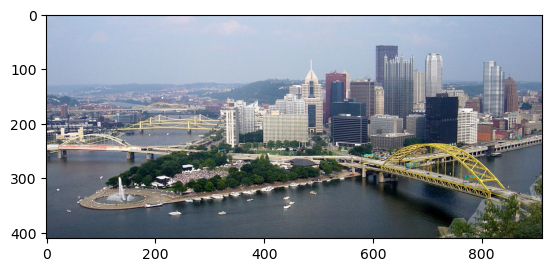

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

im = cv2.imread(os.path.relpath('../../Data/PittsburghSkyLine.jpg'))
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

plt.imshow(im)

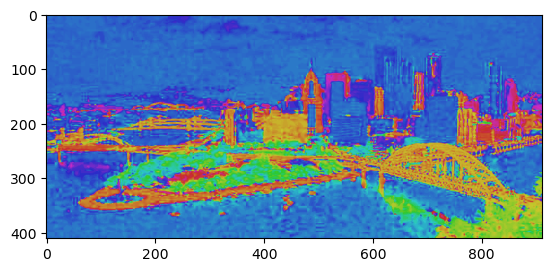

In [2]:
# Color normalized metrics

# This code uses HSV to find the dominant color from the hue channel.
hsv_image = cv2.cvtColor(im,cv2.COLOR_RGB2HSV)
[h,s,v]=cv2.split(hsv_image)

# Get rid of the saturation and value information in some way
s=np.ones(s.shape,dtype=np.uint8)*200 #np.uint8(s.mean())  
v=np.ones(v.shape,dtype=np.uint8)*200 #np.uint8(v.mean())

domcolor = cv2.cvtColor(cv2.merge((h,s,v)),cv2.COLOR_HSV2RGB)

plt.imshow(domcolor)

In [3]:
def morph_filter(img,function,kernel=np.ones((3,3))):
    # This works by creating multiple shifted copies of the image as a 4D array.  
    # The number of shifted copies is determined by the number of non-zero elements in the kernel
    # Then the function (passed as a handle) is called on the 4th dimension 

    shp=img.shape
    lst=np.argwhere(kernel==1)

    # Padding needed 
    dx=np.uint((kernel.shape[0]-1)/2)
    dy=np.uint((kernel.shape[1]-1)/2)

    img_temp=np.zeros((shp[0],shp[1],shp[2],lst.shape[0]))
    img = cv2.copyMakeBorder(img,dy,dy,dx,dx,cv2.BORDER_REFLECT)

    cnt=0
    xlist=np.int32(np.linspace(0,shp[0]-1,shp[0]))
    ylist=np.int32(np.linspace(0,shp[1]-1,shp[1]))
    for i,j in lst:
        img2=img[i+xlist,:,:]
        img_temp[:,:,:,cnt]=img2[:,j+ylist,:]
        cnt+=1

    return function(img_temp)


# This function will compute the dominant color
# This a clustering approach, finds the most represented cluster and reports the color 
def dominant_color(x,k=3):
    domcolor = x[:,:,:,0]  

    # Define criteria for K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            pix = np.float32(np.squeeze(x[i,j,:,:]).T)

            # Apply K-means clustering
            _, labels, centers = cv2.kmeans(pix, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

            # Find the most dominant color (the center with the most pixels)
            dominant_label = np.argmax(np.bincount(labels.flatten()))
            domcolor[i,j] =centers[dominant_label]

    return  np.uint8(domcolor)

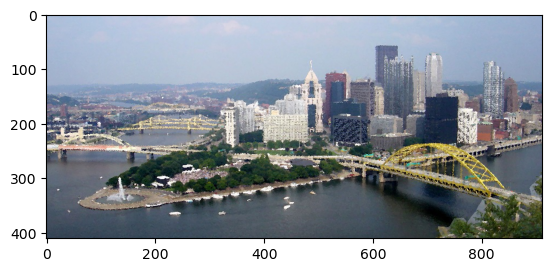

In [4]:
# Run the dominant color code above
dd = morph_filter(im,dominant_color)
plt.imshow(dd)

In [5]:
# This function computes the color layout description
from scipy.fftpack import dct
def colorlayoutdesc(x,k=3):
    colorldesc = x[:,:,0,0]
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            pix = np.float32(np.squeeze(x[i,j,0,:]))
            pix = np.reshape(pix,(k,k))
            dd = dct(dct(pix.T, norm='ortho').T, norm='ortho')

            colorldesc[i,j]=dd[0,0]
            
    return  np.uint8(colorldesc)

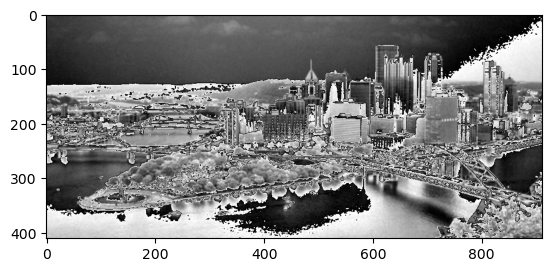

In [15]:
# Run color layout description

cld = morph_filter(cv2.cvtColor(im,cv2.COLOR_RGB2YCR_CB),colorlayoutdesc)

plt.imshow(cld,cmap='gray')

In [51]:
def texture_descriptor(x,k=11):
    x=np.uint8(x)
    x2=np.zeros((x.shape[0],x.shape[1],x.shape[3]))
    for i in range(x.shape[3]):
        x2[:,:,i]=cv2.cvtColor(x[:,:,:,i],cv2.COLOR_RGB2GRAY)

    x=x2

    stats = np.zeros((x.shape[0],x.shape[1],6))
    # Var, Entropy, Energy, Homogeneity, Jerk, inv variance 

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            pix = np.float32(np.reshape(np.squeeze(x[i,j,:]),(k,k)))
            sigma2=pix.var()
            if(not sigma2==0):
                prob = np.exp(-(pix-pix.mean())**2/sigma2/2)
                prob=prob/prob.sum()

                pix_j = np.expand_dims(np.linspace(0,k-1,k),1)*np.ones((1,k))-k/2 
                pix_i = np.ones((k,1))*np.expand_dims(np.linspace(0,k-1,k),1).T-k/2 

                stats[i,j,0] = np.sum(prob*(pix_i-pix_j)**2)  # var
                stats[i,j,1] = -np.sum(prob*np.log(prob))   # Entropy
                stats[i,j,2] = np.sum(prob**2)   # Energy
                stats[i,j,3] = np.sum(prob/(1+np.abs(pix_i-pix_j))) # Homogeneity
                stats[i,j,4] = np.sum(prob*(pix_i-pix_j)**3) # jerk
                stats[i,j,5] = np.sum(prob/(1+(pix_i-pix_j)**2)) # inv var
    
    stats[:,:,0] = stats[:,:,0]*255./stats[:,:,0].max()
    stats[:,:,1] = stats[:,:,1]*255./stats[:,:,1].max()
    stats[:,:,2] = stats[:,:,2]*255./stats[:,:,2].max()
    stats[:,:,3] = stats[:,:,3]*255./stats[:,:,3].max()
    stats[:,:,4] = stats[:,:,4]*255./stats[:,:,4].max()
    stats[:,:,5] = stats[:,:,5]*255./stats[:,:,5].max()

    return  np.uint8(stats)

In [52]:
stats = morph_filter(im,texture_descriptor,kernel=np.ones((11,11)))


Text(0.5, 1.0, 'Texture Inv Variance')

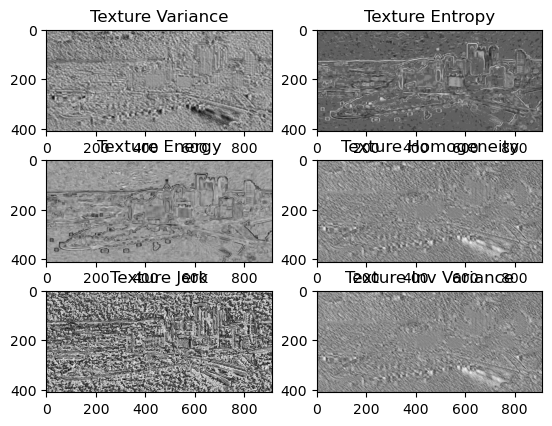

In [53]:
plt.subplot(321); plt.imshow(stats[:,:,0],cmap='gray'); plt.title('Texture Variance')
plt.subplot(322); plt.imshow(stats[:,:,1],cmap='gray'); plt.title('Texture Entropy')
plt.subplot(323); plt.imshow(stats[:,:,2],cmap='gray'); plt.title('Texture Energy')
plt.subplot(324); plt.imshow(stats[:,:,3],cmap='gray'); plt.title('Texture Homogeneity')
plt.subplot(325); plt.imshow(stats[:,:,4],cmap='gray'); plt.title('Texture Jerk')
plt.subplot(326); plt.imshow(stats[:,:,5],cmap='gray'); plt.title('Texture Inv Variance')

In [63]:
def Laws_Energy_Textures(im):
    # K. Laws "Textured Image Segmentation", Ph.D. Dissertation, University of Southern California, January 1980

    im_gray = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

    im_laws = np.zeros((im_gray.shape[0],im_gray.shape[1],9))

    L5k = np.array((1,4,6,4,1))  # ridge
    E5k = np.array((-1,-2,0,2,1))  # edge
    S5k = np.array((-1,0,2,0,-1))    # spot
    R5k = np.array((1,-4,6,-4,1))    #ripple
    W5k = np.array((-1,2,0,-2,1))     #wave

    L5E5 = np.expand_dims(L5k,1)*np.expand_dims(E5k,1).T
    L5R5 = np.expand_dims(L5k,1)*np.expand_dims(R5k,1).T
    E5S5 = np.expand_dims(E5k,1)*np.expand_dims(S5k,1).T
    S5S5 = np.expand_dims(S5k,1)*np.expand_dims(S5k,1).T
    R5R5 = np.expand_dims(R5k,1)*np.expand_dims(R5k,1).T
    L5S5 = np.expand_dims(L5k,1)*np.expand_dims(S5k,1).T
    E5E5 = np.expand_dims(E5k,1)*np.expand_dims(E5k,1).T
    E5R5 = np.expand_dims(E5k,1)*np.expand_dims(R5k,1).T
    S5R5 = np.expand_dims(S5k,1)*np.expand_dims(R5k,1).T

    kern = (L5E5,L5R5,E5S5,S5S5,R5R5,L5S5,E5E5,E5R5,S5R5) 

    for i in range(9):
        im_laws[:,:,i]=cv2.filter2D(im_gray,-1,kern[i])-cv2.filter2D(im_gray,-1,kern[i].T)

    return np.uint8(im_laws)

    

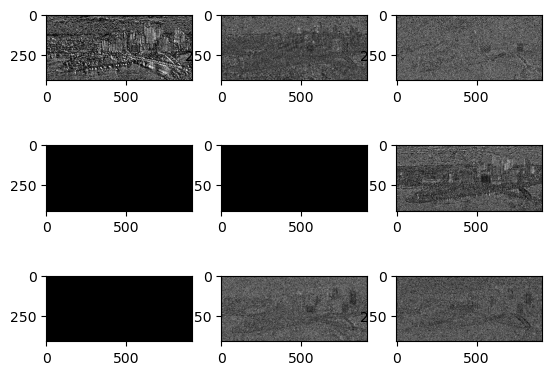

In [65]:
im_laws = Laws_Energy_Textures(im)

plt.subplot(331); plt.imshow(im_laws[:,:,0],cmap='gray')
plt.subplot(332); plt.imshow(im_laws[:,:,1],cmap='gray')
plt.subplot(333); plt.imshow(im_laws[:,:,2],cmap='gray')
plt.subplot(334); plt.imshow(im_laws[:,:,3],cmap='gray')
plt.subplot(335); plt.imshow(im_laws[:,:,4],cmap='gray')
plt.subplot(336); plt.imshow(im_laws[:,:,5],cmap='gray')
plt.subplot(337); plt.imshow(im_laws[:,:,6],cmap='gray')
plt.subplot(338); plt.imshow(im_laws[:,:,7],cmap='gray')
plt.subplot(339); plt.imshow(im_laws[:,:,8],cmap='gray')



In [142]:
def texture_corr(img,texture):
    kernel = np.ones(texture.shape)
    shp=img.shape
    lst=np.argwhere(kernel==1)

    # Padding needed 
    dx=np.uint((kernel.shape[0]-1)/2)
    dy=np.uint((kernel.shape[1]-1)/2)

    img_temp=np.zeros((shp[0],shp[1],lst.shape[0]))
    img = cv2.copyMakeBorder(img,dy,dy,dx,dx,cv2.BORDER_REFLECT)

    cnt=0
    xlist=np.int32(np.linspace(0,shp[0]-1,shp[0]))
    ylist=np.int32(np.linspace(0,shp[1]-1,shp[1]))
    for i,j in lst:
        img2=img[i+xlist,:]
        img_temp[:,:,cnt]=img2[:,j+ylist]
        cnt+=1
    
    img_temp = np.reshape(img_temp,(-1,img_temp.shape[2]))
    img_temp = img_temp-np.expand_dims(img_temp.mean(axis=1),1)*np.ones((1,img_temp.shape[1]))
    img_temp = img_temp/np.sqrt(np.expand_dims(img_temp.var(axis=1),1)*np.ones((1,img_temp.shape[1])))
    img_temp = np.nan_to_num(img_temp, nan=0, posinf=0, neginf=0)

    texture=np.reshape(texture,(-1,1))
    texture = texture-texture.mean()
    texture = texture/np.sqrt(texture.var())
    texture = np.ones((img_temp.shape[0],1))*texture.T

    imgout = np.reshape(np.sum(texture*img_temp,axis=1),shp)

    return np.uint8(cv2.normalize(imgout,None,0,255,cv2.NORM_MINMAX))



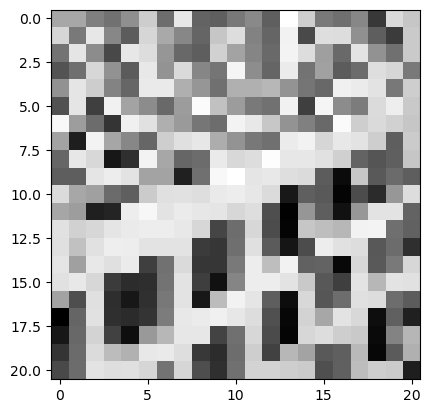

In [147]:
texture_template = cv2.imread(os.path.relpath('../../Data/building-windows.jpg'))
texture_template  = cv2.cvtColor(texture_template ,cv2.COLOR_BGR2GRAY)
texture_template = cv2.resize(texture_template,(21,21))

plt.imshow(texture_template,cmap='gray')

In [144]:
im_crr= texture_corr(im_gray,texture_template)


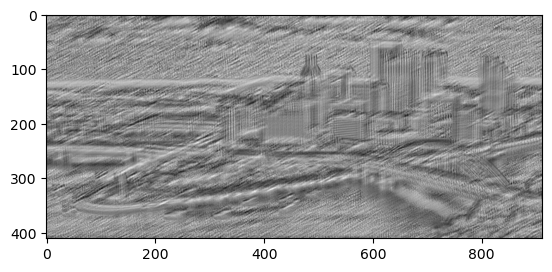

In [145]:
plt.imshow(im_crr,cmap='gray')